## This is to attempt a > 99.7% MNIST accuracy within Kaggle

The competition can be found [here](https://www.kaggle.com/competitions/digit-recognizer/overview).

Inspired by the [MNIST pytorch example](https://github.com/pytorch/examples/blob/main/mnist/main.py).


Import the necessary libraries

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import pandas as pd

Define the net class

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [1]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [5]:
conv_output_shape((32, 64), 5)

(28, 60)

Define the training function

In [9]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

Define the testing function 

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Define the main loop

In [ ]:
def main():
    # Training settings
    print("Wtf.")
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=21, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    print("Wtf.2")
    args, unknown = parser.parse_known_args()
    print(unknown)
    print(args)
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()
    print("Use CUDA: ", use_cuda)
    print("Use MPS: ", use_mps)

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "../data/mnist_cnn.pt")


if __name__ == '__main__':
    main()

Use the generated conv net to predict the Kaggle csv test

In [11]:
model = Net()
model.load_state_dict(torch.load('../data/mnist_cnn.pt'))
model.eval()  # set to evaluation mode

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for conv1.weight: copying a param with shape torch.Size([24, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([20, 24, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([24, 2000]) from checkpoint, the shape in current model is torch.Size([128, 9216]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 24]) from checkpoint, the shape in current model is torch.Size([10, 128]).

In [ ]:
data = pd.read_csv('../data/test.csv')
print("Test data length: ", len(data))
images = torch.tensor(data.values, dtype=torch.float32)
images = images.view(-1, 1, 28, 28)

# Predict using loaded model
with torch.no_grad():
    predictions = model(images)
    _, predicted_digits = torch.max(predictions, 1)  # get the class (digit) with highest probability

print(len(predicted_digits))
print(predicted_digits.numpy())
predicted_df = pd.DataFrame(predicted_digits.numpy(), columns=['Label'])
predicted_df.index += 1 
#predicted_df['ImageId'] = predicted_df.index
#print(predicted_df)
predicted_df.to_csv('../data/predicted_digits.csv', index_label='ImageId')

-=-=-=-=-=-=-=-

The following is an attempt to combine ensemble methods and transfer learning with the pytorch example. Inspired by [this kaggle notebook](https://www.kaggle.com/code/georgiisirotenko/pytorch-mnist-transferlearning-ensemble-99-714). 

In [21]:
%pip install seaborn pillow

Note: you may need to restart the kernel to use updated packages.


Note: you may need to install tk `brew install python-tk`

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transform
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import ImageTk, Image

import random
import time
import os
import copy

In [33]:
train_pd = pd.read_csv('../data/train.csv')

In [34]:
class MyDataset(Dataset):
  def __init__(self, features, labels, Transform):
    self.x = features
    self.y = labels
    self.transform = Transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.transform(self.x[index]), self.y[index]

In [35]:
def GetDf(df, Transform):
  x_features = df.iloc[:, 1:].values
  y_labels = df.label.values
  x_features = x_features.reshape(-1, 1, 28, 28)
  x_features = np.uint8(x_features)
  x_features = torch.from_numpy(x_features)
  y_labels = torch.from_numpy(y_labels)
  return MyDataset(x_features, y_labels, Transform)

In [36]:
transformer = {
 '0': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(94),
                           transform.Grayscale(num_output_channels=3), 
                           transform.ToTensor(),
                           transform.Normalize(
                                    [0.13097111880779266, 0.13097111880779266, 0.13097111880779266],
                                    [0.30848443508148193, 0.30848443508148193, 0.30848443508148193])
]),

    '1': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(94),
                           transform.Grayscale(num_output_channels=3),
                           transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transform.RandomRotation(5),
                           transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transform.ToTensor(),
                           transform.Normalize(
                                    [0.13097111880779266, 0.13097111880779266, 0.13097111880779266],
                                    [0.30848443508148193, 0.30848443508148193, 0.30848443508148193])
]),
    'val': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(94),
                           transform.Grayscale(num_output_channels=3),
                           transform.ToTensor(),
                           transform.Normalize(
                                  [0.13141274452209473, 0.13141274452209473, 0.13141274452209473],
                                  [0.30904173851013184, 0.30904173851013184, 0.30904173851013184])
    ])
}

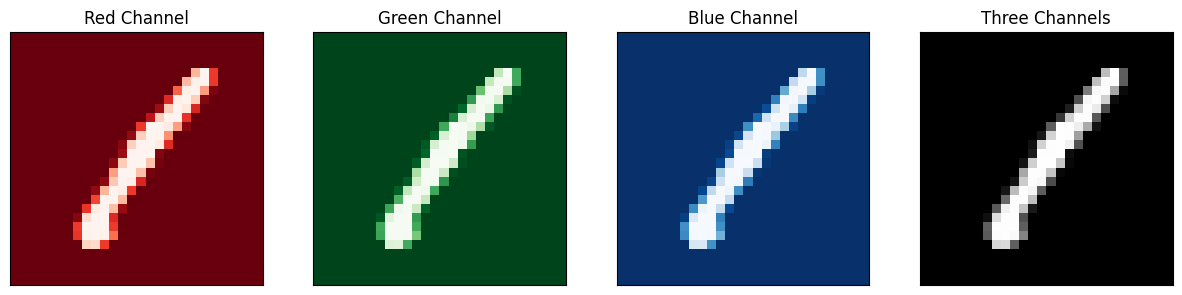

In [37]:
exampleset = GetDf(train_pd, Transform=transform.Compose([
                           transform.ToPILImage(),
                           transform.Grayscale(num_output_channels=3),
                           transform.ToTensor()
    ]))

x, y = next(iter(torch.utils.data.DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0), cmap='gray')
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

In [38]:
class TestDataset(Dataset):
    def __init__(self, features,transform=transform.Compose([
                              transform.ToPILImage(),
        transform.Resize(94),
        transform.Grayscale(num_output_channels=3),
                              transform.ToTensor(),
                              transform.Normalize(
                                  [0.13141274452209473, 0.13141274452209473, 0.13141274452209473],
                                  [0.30904173851013184, 0.30904173851013184, 0.30904173851013184])
    ])):
        self.features = features.values.reshape((-1,28,28)).astype(np.uint8)
        self.targets = None
        self.transform=transform
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return self.transform(self.features[idx])

In [39]:
def create_dataloaders(seed, test_size=0.1, df=train_pd, batch_size=50):
    
    # Create training set and validation set
    train_data, valid_data = train_test_split(df,
                                              test_size=test_size,
                                              random_state=seed)
    
    # Create Datasets
    train_dataset_0 = GetDf(train_data, Transform=transformer['0'])
    train_dataset_1 = GetDf(train_data, Transform=transformer['1'])
    
    train_dataset = ConcatDataset([train_dataset_0, train_dataset_1])

    valid_dataset = GetDf(valid_data, Transform=transformer['val'])
    
    # Create Dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)

    train_size = len(train_dataset)
    val_size = len(valid_dataset)

    return train_loader, valid_loader, train_size, val_size

In [40]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

In [46]:
def train(seed, epochs, model):
  
  # Train and valid dataloaders
  print('Creating new dataloaders...')
    
  train_loader, valid_loader, train_size, val_size = create_dataloaders(seed=seed)
  
  loaders = {'train': train_loader, 'val': valid_loader}
  
  dataset_sizes = {'train': train_size, 'val': val_size}
  
  print('Creating a model {}...'.format(seed))
  # todo - ARGS
  use_cuda = torch.cuda.is_available() # not args.no_cuda and
  use_mps = torch.backends.mps.is_available() # not args.no_mps and
  print("Use CUDA: ", use_cuda)
  print("Use MPS: ", use_mps)
  
  # TODO: Seed
  # torch.manual_seed(args.seed)
  # TODO :: 
  #   if use_cuda:
  #     device = torch.device("cuda")
  #   elif use_mps:
  #     device = torch.device("mps")
  #   else:
  device = torch.device("cpu")
  
  model.to(device)  
  criterion = nn.CrossEntropyLoss()
  if seed==2 or seed==3:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  #   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
  
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0
  
      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
  
        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
  
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)
  
  #       if phase == 'train':
  #           acc = 100. * running_corrects.double() / dataset_sizes[phase]
  #           scheduler.step(acc)
  
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)
  
  
  model.load_state_dict(best_model)
  
  for param in model.parameters():
        param.requires_grad=True
  
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
  #   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0
  
      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
  
        optimizer.zero_grad()
  
        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)
  
  #       if phase == 'train':
  #         acc = 100. * running_corrects.double() / dataset_sizes[phase]
  #         scheduler.step(acc)
  
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step() 
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)
  
  model.load_state_dict(best_model)
    
  model.eval() # Evaluation mode -> Turn off dropout
  test_pred = torch.LongTensor()
  
  if use_cuda:
    test_pred = test_pred.cuda()
        
  with torch.no_grad(): # Turn off gradients for prediction, saves memory and computations
    for features in test_loader:
        
        if use_cuda:
            features = features.cuda()
  
            # Get the softmax probabilities
            outputs = model(features)
            # Get the prediction of the batch
            _, predicted = torch.max(outputs, 1)
            # Concatenate the prediction
            test_pred = torch.cat((test_pred, predicted), dim=0)
    
  model_name = 'model_' + str(seed + 1)
  ensemble_df[model_name] = test_pred.cpu().numpy()
  print('Prediction Saved! \n') 

In [14]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=10, bias=True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/z/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|█████████████████████████████████████| 30.8M/30.8M [00:04<00:00, 6.50MB/s]


In [16]:
densenet121_1 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_1.parameters():
  param.requires_grad=False

densenet121_1.classifier = nn.Linear(in_features=densenet121_1.classifier.in_features, out_features=10, bias=True)

In [17]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=10, bias=True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/z/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|█████████████████████████████████████| 49.7M/49.7M [00:07<00:00, 7.02MB/s]


In [18]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=10, bias=True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/z/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|███████████████████████████████████████| 171M/171M [00:26<00:00, 6.72MB/s]


In [32]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, 10, bias=True)

In [47]:
# Create test_loader
submit_df = pd.read_csv('../data/sample_submission.csv')
test_df = pd.read_csv('../data/test.csv')
test_dataset = TestDataset(test_df)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

ensemble_df = submit_df.copy()

num_models = 5
num_epochs = 10

models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
   train(seed=seed, epochs=num_epochs, model=models[seed])

Creating new dataloaders...
Creating a model 0...
Use CUDA:  False
Use MPS:  True


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'MyDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.5

RuntimeError: DataLoader worker (pid(s) 36974) exited unexpectedly